# Calculate sidewalk width
Using centerline extraction (also called skeleton line, axis line, or medial line extraction)

In [1]:
# Add project src to path.
import set_path

import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from shapely.ops import linemerge
from shapely.geometry import box

import geopandas as gpd
from centerline.geometry import Centerline

from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()

import upcp.utils.bgt_utils as bgt_utils
import upcp.utils.las_utils as las_utils

import upc_sw.poly_utils as poly_utils

C:\Users\jansen252\Documents\P3_AforAll\DS\Urban_PointCloud_Sidewalk_Width\venv\lib\site-packages\geopandas\_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


## Read the sidewalk and obstacle data

In [2]:
# Get dimensions of point cloud tile
tilecode = '2386_9702'
((x_min, y_max), (x_max, y_min)) = las_utils.get_bbox_from_tile_code(tilecode, padding=1)

# Get sidewalk polygons
bgt_road_file = '../datasets/bgt/bgt_voetpad.csv'
bgt_sidewalk_reader = bgt_utils.BGTPolyReader(bgt_file=bgt_road_file)

sidewalk_polygons = bgt_sidewalk_reader.filter_tile(
                            tilecode, bgt_types=['voetpad'],
                            padding=0, offset=0,
                            merge=False)

# Read sidewalk with obstacle data
df = gpd.read_file('../datasets/obstacles/sidewalks_with_obstacles.shp')

# A CRS tells Python how those coordinates relate to places on the Earth. Rijksdriehoek = epsg:28992
crs = 'epsg:28992' #local crs

(485099.0, 485151.0)

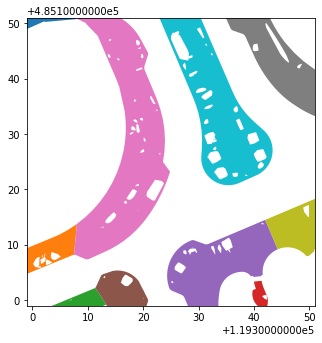

In [3]:
# Plot
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])

df.plot(ax=ax, figsize=(4, 4), cmap='tab10')

ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])

## Merge the sidewalk polygons

In [4]:
df_dissolved = gpd.GeoDataFrame(geometry=gpd.GeoSeries([geom for geom in df.unary_union.geoms]))
df_exploded = gpd.GeoDataFrame(df_dissolved.geometry.explode(index_parts=True))

In [5]:
# Ignore sidewalk polygons that are too small
min_area_size = 5
df_exploded = df_exploded[df_exploded.geometry.area > min_area_size]

(485099.0, 485151.0)

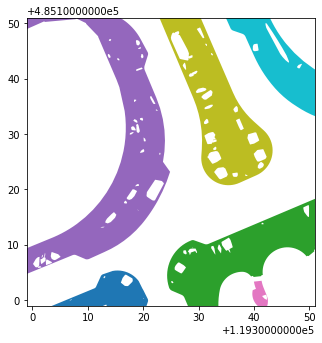

In [6]:
# Plot
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])

df_exploded.plot(ax=ax, figsize=(4, 4), cmap='tab10')

ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])

## Calculate the centerlines

In [7]:
# if you get an error here, make sure you use tqdm>=4.61.2
df_exploded['centerlines'] = df_exploded.progress_apply(lambda row: Centerline(row.geometry), axis=1)
df_exploded = df_exploded.set_geometry('centerlines')

  0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\jansen252\Documents\P3_AforAll\DS\Urban_PointCloud_Sidewalk_Width\venv\lib\site-packages\centerline\geometry.py:34: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  self._input_geometry = input_geometry
C:\Users\jansen252\Documents\P3_AforAll\DS\Urban_PointCloud_Sidewalk_Width\venv\lib\site-packages\centerline\geometry.py:35: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  self._interpolation_distance = abs(interpolation_distance)
C:\Users\jansen252\Documents\P3_AforAll\DS\Urban_PointCloud_Sidewalk_Width\venv\lib\site-packages\centerline\geometry.py:40: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  self._min_x, self._min_y = self._get_reduced_coordinates()
C:\Users\jansen252\Documents\P3_AforAll\DS\Urban_PointC

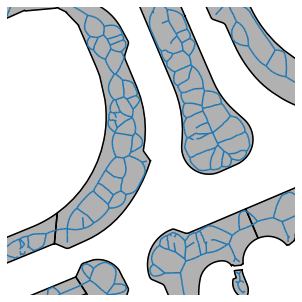

In [8]:
# Plot
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')

for poly in sidewalk_polygons:
    x,y = poly.exterior.xy
    plt.fill(x, y, c="black", alpha=0.30)
    plt.plot(x, y, c="black")

df_exploded.plot(ax=ax, figsize=(4, 4))

ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])
plt.savefig('../media/examples/centerlines.png', bbox_inches='tight')

## Remove Short Line Ends

In [9]:
df_exploded['centerlines'] = df_exploded['centerlines'].progress_apply(linemerge)

  0%|          | 0/6 [00:00<?, ?it/s]

In [10]:
df_exploded['centerlines'] = df_exploded['centerlines'].progress_apply(poly_utils.remove_short_lines)

  0%|          | 0/6 [00:00<?, ?it/s]

In [11]:
df_exploded.head()

,,geometry,centerlines
0,0,"POLYGON ((119345.225 485033.611, 119346.790 48...","MULTILINESTRING ((119291.211 485091.520, 11929..."
1,0,"POLYGON ((119339.167 485104.658, 119339.031 48...","MULTILINESTRING ((119326.504 485107.894, 11932..."
2,0,"POLYGON ((119307.309 485108.166, 119307.259 48...","MULTILINESTRING ((119204.001 485068.098, 11920..."
3,0,"POLYGON ((119341.466 485103.143, 119341.503 48...","MULTILINESTRING ((119341.020 485101.572, 11934..."
4,0,"POLYGON ((119337.304 485135.455, 119337.957 48...","MULTILINESTRING ((119325.089 485154.523, 11932..."


(485099.0, 485151.0)

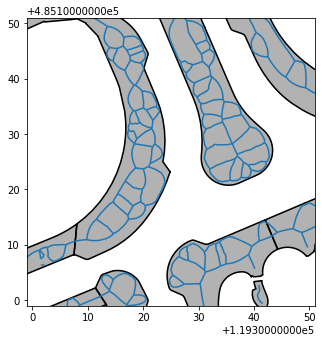

In [12]:
# Plot
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])

for poly in sidewalk_polygons:
    x,y = poly.exterior.xy
    plt.fill(x, y, c="black", alpha=0.30)
    plt.plot(x, y, c="black")

df_exploded.plot(ax=ax, figsize=(4, 4))

ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])

## Get Sidewalk Widths

In [13]:
df_exploded['centerlines'] = df_exploded['centerlines'].progress_apply(lambda row: row.simplify(0.2, preserve_topology=True))

  0%|          | 0/6 [00:00<?, ?it/s]

In [14]:
df_exploded['segments'] = df_exploded['centerlines'].progress_apply(poly_utils.get_segments)
df_exploded.head(1)

  0%|          | 0/6 [00:00<?, ?it/s]

,,geometry,centerlines,segments
0,0,"POLYGON ((119345.225 485033.611, 119346.790 48...","MULTILINESTRING ((119291.211 485091.520, 11929...",[LINESTRING (119291.21117192185 485091.5198779...


In [15]:
df_exploded[['avg_distances', 'min_distances']] = df_exploded.progress_apply(lambda row: poly_utils.get_avg_distances(row), axis=1)
df_exploded.head(1)

  0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\jansen252\Documents\P3_AforAll\DS\Urban_PointCloud_Sidewalk_Width_m\Urban_PointCloud_Sidewalk_Width\src\upc_sw\poly_utils.py:97: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for point in points:


,,geometry,centerlines,segments,avg_distances,min_distances
0,0,"POLYGON ((119345.225 485033.611, 119346.790 48...","MULTILINESTRING ((119291.211 485091.520, 11929...",[LINESTRING (119291.21117192185 485091.5198779...,"[1.837810813582637, 2.5008896829519838, 2.5193...","[1.4802729577733358, 2.5008896829519838, 2.519..."


In [16]:
data = {'geometry': [], 'avg_width': [], 'min_width': []}

for i, row in df_exploded.iterrows():
    
    for segment in row.segments:
        data['geometry'].append(segment)
    
    for avg_distance in row.avg_distances:
        data['avg_width'].append(avg_distance * 2)
    
    for min_distance in row.min_distances:
        data['min_width'].append(min_distance * 2)
        
df_segments = pd.DataFrame(data)
df_segments = gpd.GeoDataFrame(df_segments, crs=crs, geometry='geometry')
df_segments.head(1)

C:\Users\jansen252\Documents\P3_AforAll\DS\Urban_PointCloud_Sidewalk_Width\venv\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


,geometry,avg_width,min_width
0,"LINESTRING (119291.211 485091.520, 119291.754 ...",3.675622,2.960546


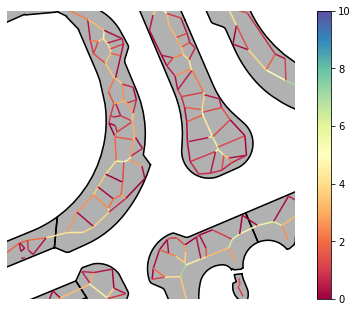

In [17]:
# Plot
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')

for poly in sidewalk_polygons:
    x,y = poly.exterior.xy
    plt.fill(x, y, c="black", alpha=0.30)
    plt.plot(x, y, c="black")

df_segments.plot(ax=ax, figsize=(4, 4), column='min_width', cmap='Spectral', vmin=0, vmax=10, legend=True)
    
ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])
plt.savefig('../media/examples/sidewalk_width.png', bbox_inches='tight')

In [18]:
# Width in meters
df_segments['avg_width'] = round(df_segments['avg_width'] * 10) / 10
df_segments['min_width'] = round(df_segments['min_width'] * 10) / 10
df_segments.head()

,geometry,avg_width,min_width
0,"LINESTRING (119291.211 485091.520, 119291.754 ...",3.7,3.0
1,"LINESTRING (119291.754 485092.846, 119291.964 ...",5.0,5.0
2,"LINESTRING (119291.964 485093.113, 119291.840 ...",5.0,5.0
3,"LINESTRING (119291.964 485093.113, 119292.422 ...",4.9,4.9
4,"LINESTRING (119292.422 485093.064, 119306.350 ...",3.2,2.6


## Check coverage of point cloud data on sidewalks

In [ ]:
pc_data_folder = '../datasets/pointclouds/'

all_tiles = las_utils.get_tilecodes_from_folder(f'{pc_data_folder}m3c2/')

In [ ]:
def get_tile_dimensions(tilecode):
    ((x_min, y_max), (x_max, y_min)) = las_utils.get_bbox_from_tile_code(tilecode, padding=0)
    tile_polygon = box(*[x_min, y_min, x_max, y_max], ccw=True)
    return tile_polygon

tile_dimensions = [get_tile_dimensions(tile) for tile in all_tiles]

In [ ]:
df_tile_dimensions = gpd.GeoDataFrame(crs=crs, geometry=tile_dimensions)

# When True, take the union of the polygons
if len(tile_dimensions) > 1:
    df_tile_dimensions = gpd.GeoDataFrame(geometry=gpd.GeoSeries([geom for geom in df_tile_dimensions.unary_union.geoms]))
    df_tile_dimensions = gpd.GeoDataFrame(df_tile_dimensions.geometry.explode(index_parts=True))

In [ ]:
# Check if obstacle intersects with sidewalk polygon
for i, row in df_segments.iterrows():
    for j, row_tile in df_tile_dimensions.iterrows():
        pc_coverage = row.geometry.intersects(row_tile.geometry)
        # Only add to column if True
        if pc_coverage:
            # continue here in the loop not possible -> obstacle can be on multiple sidewalks 
            df_segments.loc[i, 'pc_coverage'] = pc_coverage

In [ ]:
df_covered = df_segments[df_segments['pc_coverage'] == True]
df_covered.head(5)

## Store output

In [19]:
df_projected = df_segments.to_crs('EPSG:4326')
with open('../datasets/output/intermediate_output_segments.geojson', 'w') as f:
    f.write(df_projected.to_json())

In [ ]:
df_projected = df_segments.to_crs('EPSG:4326')
with open('../datasets/output/intermediate_output_segments.geojson', 'w') as f:
    f.write(df_projected.to_json())